**Kuramoto model - Lineal case**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import csv

In [2]:
N = 3 # number of oscillators
k = 1. # coupling strength

# intrinsic angular frequencies
w1 = 0.
w2 = 0.
w3 = 0.
w = np.array([w1, w2, w3])*2.0*np.pi # vector with the intrinsic angular velocities 

A = np.array([[0, 1, 1],
              [1, 0, 1],
              [1, 1, 0]]) # adjacency matrix
L = np.array([[2, -1, -1],
              [-1, 2, -1],
              [-1, -1 ,2]])

In [3]:
# Derivative of the function (dtheta/dt)
def derivative(t, theta): # theta = (theta1, theta2, theta3,..., thetaN) [vector]
    dtheta = np.zeros(len(theta))
    dtheta += w
    for i in range(len(theta)): # len(theta) = N
        for j in range(len(theta)): 
                #dtheta[i] += k*A[i,j]*(theta[j]-theta[i])  
                dtheta[i] += - k*L[i,j]*theta[j]
    return dtheta  

# Runge-Kutta 4 integration method
def rk4_multivariable(t, h, theta0):
    theta_rk4 = np.zeros(len(theta0))
    k1 = derivative(t, theta0)
    k2 = derivative(t, theta0+(h/2.)*k1)
    k3 = derivative(t, theta0+(h/2.)*k2)
    k4 = derivative(t, theta0+h*k3)
    theta_rk4 = theta0 + (h/6.)*(k1 + 2*k2 + 2*k3 + k4)  
    
    for i in range(len(theta_rk4)):        
        # We limit the solution between -pi and pi   
        if np.pi < theta_rk4[i] < 2*np.pi:
            theta_rk4[i] = theta_rk4[i] - 2*np.pi
        if -np.pi < theta_rk4[i] < -2*np.pi:
            theta_rk4[i] = theta_rk4[i] + 2*np.pi        
    return theta_rk4               

In [4]:
# Synchronization order parameter 
def sync_order_parameter(N, theta): #(at a given time t)
    r_var = 0
    for i in range(len(theta)):
        r_var+=np.exp(1j*theta[i])
    r_var = (1./float(N))*r_var
    return r_var 

In [5]:
file = open("results_lineal.txt", "w")
writer = csv.writer(file, delimiter = ' ')

# Initial conditions
t0 = 0
h = 0.0001 # delta t
steps = 100000
theta0 = np.array([0.1, -0.1, 0.2])*np.pi  # t=0 (theta1, theta2, theta3) - Values next to zero (convergence guarantee)
order_p0 = abs(sync_order_parameter(N, theta0))

writer.writerow((t0, theta0[0], theta0[1], theta0[2], order_p0))

# integration over time
for n in range(1, steps):
    t = t0 + n*h # time
    theta = rk4_multivariable(t, h, theta0) # vector with the solution of each time iteration
    theta0 = theta
    r = abs(sync_order_parameter(N, theta)) # modulus of the sync order parameter
    
    if n%10==0:
        writer.writerow(("{:.4f}".format(t), "{:.12f}".format(theta[0]), "{:.12f}".format(theta[1]), "{:.12f}".format(theta[2]), "{:.12f}".format(r)))

file.close()    

**DATA PROCESSING**

In [2]:
N = 3 # number of oscillators
steps = 10000

time = np.zeros(steps)
theta = np.zeros((steps,N))
order_p = np.zeros(steps)

lines = 0 # counter
with open("results_lineal.txt","r") as file2:
    for line in file2:
        line = line.split(' ')
        time[lines] = float(line[0])
        theta[lines]=line[1:4:]
        order_p[lines] = line[4]
        lines+=1 

<ipython-input-83-2de28a59547a>:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-83-2de28a59547a>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


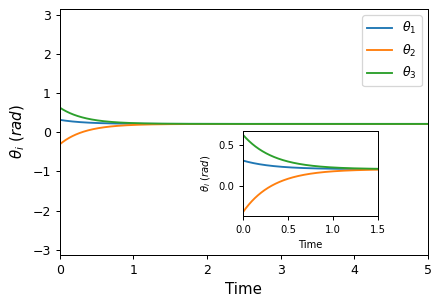

In [83]:
fig, ax1 = plt.subplots(figsize=(5,3.5), dpi=90)
ax1.plot(time,theta[:,0], label=r'$\theta_{1}$')  
ax1.plot(time,theta[:,1], label=r'$\theta_{2}$') 
ax1.plot(time,theta[:,2], label=r'$\theta_{3}$') 
plt.ylabel(r'$\theta_{i} \ (rad)$', fontsize=12)
plt.xlabel('Time', fontsize=12)
ax1.legend(loc='upper right') #bbox_to_anchor=(1, 0.5)
plt.ylim((-np.pi, np.pi))
plt.xlim((0,5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

left, bottom, width, height = [0.55, 0.3, 0.3, 0.27]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(time,theta[:,0], label=r'$\theta_{1}$')
ax2.plot(time,theta[:,1], label=r'$\theta_{2}$') 
ax2.plot(time,theta[:,2], label=r'$\theta_{3}$') 
plt.xlim((0,1.5))
plt.ylabel(r'$\theta_{i} \ (rad)$', fontsize=8)
plt.xlabel('Time', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


plt.tight_layout()

fig.savefig('lineal.png')
fig.show()

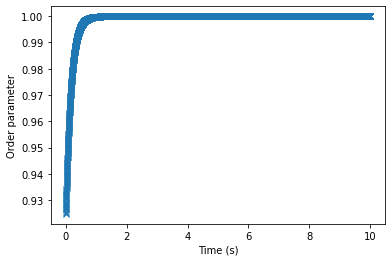

In [8]:
plt.figure()
plt.ylabel('Order parameter')
plt.xlabel('Time (s)')
plt.plot(time,order_p,'x')  
plt.savefig('order_p_lineal.png')
plt.show()

Phase difference

In [12]:
delta_theta_lin = np.zeros(steps)
for t in range(len(time)):
    delta_lin = 0
    for i in range(N-1):
        for j in range(i+1, N):
            difference = theta[t][j]-theta[t][i]
            checker = (int(difference/np.pi) - int(difference/(2.0*np.pi)))*2.0*np.pi
            #print(checker)
            delta_lin += (difference-checker)*(difference-checker)
    delta_lin = (1./float(N))*delta_lin
    delta_theta_lin[t] = delta_lin 

In [13]:
delta_theta_lin = np.zeros(steps)
delta_theta_aux = np.zeros(3)
delta_theta_dev = np.zeros(steps)
for t in range(len(time)):
    delta_lin = 0.
    delta_theta_aux[:]=0.
    for i in range(N-1):
        for j in range(i+1, N):
            difference = theta[t][i]-theta[t][j]
            checker = (int(difference/np.pi) - int(difference/(2.0*np.pi)))*2.0*np.pi
            #print(checker)
            delta_theta_aux[i+j-1]=(difference-checker)*(difference-checker)
            delta_lin += (difference-checker)*(difference-checker)
    delta_lin = (1./float(N))*delta_lin
    delta_theta_lin[t] = delta_lin 
    delta_theta_dev[t] = np.std(delta_theta_aux)

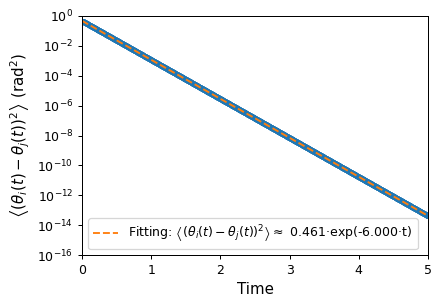

y = ax + b
a = -6.00000000000157 , b = 0.46058153871763263 a_err = [ 2.04272183e-26 -7.79338519e-28] b_err= [-7.79338519e-28  5.98255414e-29]


In [84]:
# log-lin scale

def g(x,a,b):
    return b*np.exp(a*x)

x = time #[time[i] for i in range(0,len(time),5)]
y = delta_theta_lin
fit, cov2 = curve_fit(g,x,y)

plt.figure(figsize=(5,3.5), dpi=90)
plt.ylabel(r'$\left<(\theta_{i}(t) - \theta_{j}(t))^{2}\right>$ (rad$^{2}$)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.yscale('log')
plt.plot(x, y, '.')
plt.plot(x, g(x, fit[0], fit[1]), '--', label=r'Fitting: $\left<(\theta_i (t) - \theta_j (t))^2 \right> \approx$ {:.3f}·exp({:.3f}·t)'.format(fit[1],fit[0]))

plt.xlim([0,5])
plt.ylim([10**(-16),1])

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#plt.fill_between(x, y - delta_theta_dev, y + delta_theta_dev,color='blue', alpha=0.1)

plt.legend()
plt.tight_layout()
plt.savefig('delta_theta_lin.png')
plt.show()

print('y = ax + b')
print('a =',fit[0],',','b =', fit[1],'a_err =',cov2[0] ,'b_err=',cov2[1])

#La desv. stand. disminueix de la mateixa manera que ho fa wl valor mitjà.Anar amb compte amb eixos ja que distàncies iguals en cartesianes no és log.